In [1]:
from __future__ import division,print_function

import os, json
from os import walk
from glob import glob
import pandas as pd
import scipy as sp
import numpy as np
np.set_printoptions(precision=4, linewidth=100)

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

Using TensorFlow backend.


In [2]:
data_path =  '../data1/'

fold_no_list = ['fold1', 'fold2', 'fold3' ,'fold4', 'fold5']
train_type_list = ['train', 'test']
magnif_list = ['40X', '100X', '200X', '400X']
lesion_list = ['benign', 'malignant']

patch_xsize = 350
patch_ysize = 230

c_fold = 'fold1'
c_magnif = '40X'

In [3]:
def img_norm(img, y=patch_ysize, x=patch_xsize):
    img = sp.misc.imresize(img, (y,x)).astype(np.float)
    img -= np.mean(img, axis=2, keepdims=True)
    img /= (np.std(img, axis=2, keepdims=True) + 1e-7)
    return img

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, '%.2f'%cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
        
    #plt.tight_layout()    
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted Value')

# Visualization

In [ ]:
img = sp.misc.imread('../data/fold1/train/40X/benign/SOB_B_PT-14-22704-40-001.png')

In [ ]:
plt.imshow(img)

# Organise Training Set

In [ ]:
fold_no_list = ['fold1', 'fold2', 'fold3' ,'fold4', 'fold5']
train_type_list = ['train', 'test']
magnif_list = ['40X', '100X', '200X', '400X']
lesion_list = ['benign', 'malignant']

for fold_no in fold_no_list:
    for train_type in train_type_list:
        for magnif in magnif_list:           
            for lesion in lesion_list:
                my_path = data_path+'{}/{}/{}/{}'.format(fold_no, train_type, magnif, lesion)

                if not os.path.exists(my_path):
                    os.makedirs(my_path)       
            
            f = []
            my_path2 = data_path+'{}/{}/{}/'.format(fold_no, train_type, magnif)
            for (dirpath, dirnames, filenames) in walk(my_path2):
                f.extend(filenames)
                break    
            for file in f:
                if file[4] == 'M': 
                    os.rename(my_path2+file, my_path2+'malignant/' + file)
                elif file[4] == 'B': 
                    os.rename(my_path2+file, my_path2+'benign/' + file)

# Create patient detail table

In [4]:
df = pd.DataFrame()
for train_type in train_type_list:
    for magnif in magnif_list:           
        for lesion in lesion_list:
            my_path = data_path+c_fold+'/{}/{}/{}'.format(train_type, magnif, lesion)
            file_list = []
            for (dirpath, dirnames, filenames) in walk(my_path):
                file_list.extend(filenames)
                break   
            for file in file_list:
                und_pos = [pos for pos, char in enumerate(file) if char == '_']
                dash_pos = [pos for pos, char in enumerate(file) if char == '-']
                dot_pos = [pos for pos, char in enumerate(file) if char == '.']
                df = df.append({'name': file,\
                            'patient': file[dash_pos[1]+1:dash_pos[2]],\
                            'lesion': lesion,\
                            'magnification':file[dash_pos[2]+1:dash_pos[3]]},\
                            ignore_index=True)

# Inception

In [5]:
base_model = InceptionV3(include_top=False, weights=None, input_shape=(patch_ysize,patch_xsize,3) )

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [9]:
batch_size = 16

train_datagen = image.ImageDataGenerator(
        preprocessing_function=img_norm,
        horizontal_flip=True,
        vertical_flip = True)

test_datagen = image.ImageDataGenerator(preprocessing_function=img_norm)

print('Training Images')
train_generator = train_datagen.flow_from_directory(
        data_path+c_fold+'/train/'+c_magnif,
        target_size=(patch_ysize, patch_xsize),
        batch_size=batch_size)

print('Testing Images')
validation_generator = test_datagen.flow_from_directory(
        data_path+c_fold+'/test/'+c_magnif,
        target_size=(patch_ysize, patch_xsize),
        batch_size=batch_size)

Training Images
Found 1250 images belonging to 2 classes.
Testing Images
Found 745 images belonging to 2 classes.


In [10]:
model.fit_generator(
        train_generator,
        steps_per_epoch = int(1250/batch_size),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=int(750/batch_size),
        verbose=2)

Epoch 1/20
32s - loss: 0.6527 - binary_accuracy: 0.7925 - val_loss: 1.5769 - val_binary_accuracy: 0.6576
Epoch 2/20
28s - loss: 0.5409 - binary_accuracy: 0.8030 - val_loss: 0.5705 - val_binary_accuracy: 0.7283
Epoch 3/20
28s - loss: 0.5749 - binary_accuracy: 0.7709 - val_loss: 2.4450 - val_binary_accuracy: 0.6576
Epoch 4/20
27s - loss: 0.4638 - binary_accuracy: 0.8198 - val_loss: 1.0541 - val_binary_accuracy: 0.6658
Epoch 5/20
27s - loss: 0.4095 - binary_accuracy: 0.8254 - val_loss: 0.4617 - val_binary_accuracy: 0.8261
Epoch 6/20
27s - loss: 0.4004 - binary_accuracy: 0.8333 - val_loss: 0.4857 - val_binary_accuracy: 0.8342
Epoch 7/20
27s - loss: 0.3838 - binary_accuracy: 0.8437 - val_loss: 1.4122 - val_binary_accuracy: 0.8410
Epoch 8/20
27s - loss: 0.3731 - binary_accuracy: 0.8517 - val_loss: 1.2608 - val_binary_accuracy: 0.8424
Epoch 9/20
27s - loss: 0.3903 - binary_accuracy: 0.8414 - val_loss: 0.4947 - val_binary_accuracy: 0.8668
Epoch 10/20
27s - loss: 0.3582 - binary_accuracy: 0.863

In [11]:
for lesion in lesion_list:
    df[lesion+'_pred'] = np.nan

for lesion in lesion_list:
    my_path = data_path+c_fold+'/test/'+c_magnif+'/{}'.format(lesion)
    file_list = []
    for (dirpath, dirnames, filenames) in walk(my_path):
        file_list.extend(filenames)
        break   
    for file in file_list:
        img = sp.misc.imread(data_path+c_fold+'/test/'+c_magnif+'/{}/{}'.format(lesion, file)) 
        img = img_norm(img)
        img = np.expand_dims(img, axis=0)
        
        df.loc[df['name']==file, [lesion+'_pred' for lesion in lesion_list]] = model.predict(img, batch_size=1, verbose=0)[0]

In [12]:
df2 = df.copy()
df2 = df2.dropna(axis=0, how='any')

for lesion in lesion_list:
    df2[lesion+'_int_pred'] = 1*(lesion+'_pred' == df2[[lesion+'_pred' for lesion in lesion_list]].idxmax(axis=1))   
    
df2['lesion_pred'] = np.nan
for index, row in df2.iterrows():
    for lesion in lesion_list:
        if row[lesion+'_int_pred'] == 1:
            df2.loc[index, 'lesion_pred'] = lesion

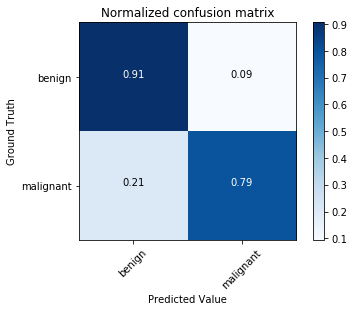

In [13]:
y_test = df2['lesion']
y_pred = df2['lesion_pred']

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=lesion_list, normalize=True, title='Normalized confusion matrix')